## Explore TF isoform expression data

kaia cleaning up luke's original code

In [1]:
import os
import itertools
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import sys


# import utils
sys.path.append("../")

from data_loading import (load_full_y2h_data_including_controls,
                          load_annotated_gencode_tfs,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_seq_comparison_data,
                          load_gtex_gencode,
                          load_developmental_tissue_expression_gencode,
                          load_tf_families)

In [2]:
np.random.seed(2023)

In [3]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [4]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## 1. load Gencode TFs + GTEx + Dev RNA-seq

In [5]:
tfs = load_annotated_gencode_tfs()

df_gtex, metadata_gtex, genes_gtex = load_gtex_gencode()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_gencode()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())
all_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values() for orf in tf.isoforms}
alt_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and not orf.is_MANE_select_transcript}
ref_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and orf.is_MANE_select_transcript}

100%|██████████| 1635/1635 [00:31<00:00, 52.52it/s]


reading from cache
reading from cache


In [6]:
len(tfs)

1635

In [7]:
metadata_dev.shape

(313, 42)

In [8]:
metadata_gtex.shape

(2485, 49)

In [9]:
len(all_isos)

4144

In [10]:
len(ref_isos)

1514

In [11]:
len(alt_isos)

2305

In [12]:
(means_gtex > 1).any(axis=1).value_counts()

True     3165
False     979
dtype: int64

In [13]:
(means_gtex.loc[means_gtex.index.isin(alt_isos), :].sum(axis=1) >= 1).sum()

1842

## 2. cumulative plot: % of samples with isoforms ≥ 1 TPM in both datasets

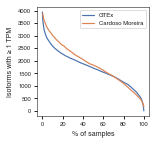

In [14]:
n_samples_gtex = df_gtex.shape[1]
n_samples_gt1_gtex = (df_gtex >= 1).sum(axis=1)
n_samples_dev = df_dev.shape[1]
n_samples_gt1_dev = (df_dev >= 1).sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.plot([i / n_samples_gtex * 100 for i in range(1, n_samples_gtex + 1)],
        [(n_samples_gt1_gtex >= i).sum() for i in range(1, n_samples_gtex + 1)],
        label='GTEx')
ax.plot([i / n_samples_dev * 100 for i in range(1, n_samples_dev + 1)],
        [(n_samples_gt1_dev >= i).sum() for i in range(1, n_samples_dev + 1)],
        label='Cardoso Moreira')
ax.legend()
ax.set_ylabel('Isoforms with ≥ 1 TPM')
ax.set_xlabel('% of samples')
fig.savefig('../../figures/n-isoforms-vs-pct-samples_GTEx-vs-development_line-plot.pdf',
            bbox_inches='tight')

## 3. isoforms per family

In [15]:
# number of isoforms vs gene expression, publications, and exons 
tpm_per_gene = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .sum()
                .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
                .mean())
gn = tpm_per_gene.max(axis=1).rename('TPM - gene-level, max across GTEx tissues').to_frame()
gn['n_isoforms'] = gn.index.map(genes_gtex.value_counts())

In [16]:
fam = load_tf_families()
gn['family'] = gn.index.map(fam)
gn['is_nuclear_receptor'] = (gn['family'] == 'Nuclear receptor')
gn.head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,family,is_nuclear_receptor
AC008770.3,0.339530,2,C2H2 ZF,False
AC023509.3,4.475325,1,bZIP,False
AC092835.1,0.884619,1,C2H2 ZF,False
AC138696.1,1.760060,1,C2H2 ZF,False
ADNP,9157.752828,3,Homeodomain,False


In [17]:
len(gn)

1635

In [18]:
len(gn[gn["n_isoforms"] > 1])

992

In [19]:
gn.n_isoforms.mean()

2.5345565749235472

In [112]:
gn[gn["family"] == "Homeodomain"].n_isoforms.mean()

1.8041237113402062

In [113]:
gn[gn["family"] == "Nuclear receptor"].n_isoforms.mean()

3.8260869565217392

In [20]:
gn.sort_values(by="n_isoforms", ascending=False).head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,family,is_nuclear_receptor
CREM,372.514410,25,bZIP,False
TCF4,13.551768,23,bHLH,False
NFATC4,198.651682,23,Rel,False
NR1I3,65.437841,21,Nuclear receptor,True
MYT1L,47.689698,18,C2H2 ZF,False


In [21]:
fam_members = pd.DataFrame(gn['family'].value_counts()).reset_index()
fam_members_ov12 = fam_members[fam_members["family"] >= 12]
fam_members_ov12

,index,family
0,C2H2 ZF,745
1,Homeodomain,194
2,bHLH,108
3,Unknown,69
4,bZIP,54
5,Forkhead,49
6,Nuclear receptor,46
7,HMG/Sox,30
8,Ets,27
9,T-box,17


In [131]:
def collapse_families(row, families_to_keep):
    if row['family'] in families_to_keep:
        return row['family']
    else:
        return 'Other'
    
gn['family_updated'] = gn.apply(collapse_families, axis=1, 
                                families_to_keep=list(fam_members[fam_members['family'] >=20]['index']))
gn.family_updated.value_counts()

C2H2 ZF             745
Other               313
Homeodomain         194
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
Name: family_updated, dtype: int64

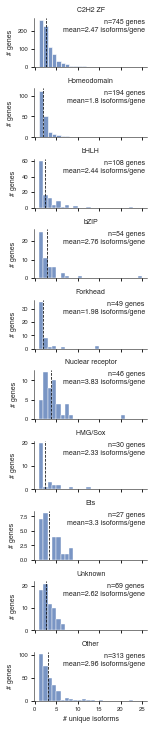

In [134]:
def annotate(data, **kws):
    n = len(data)
    mean = data.n_isoforms.mean()
    ax = plt.gca()
    ax.text(0.98, 0.98, "n=%s genes\nmean=%s isoforms/gene" % (n, np.round(mean, 2)), transform=ax.transAxes,
            ha="right", va="top")
    ax.axvline(x=mean, linestyle="dashed", color="black", linewidth=0.75)

g = sns.FacetGrid(gn, row="family_updated", sharex=True, sharey=False, height=1, aspect=2,
                  row_order=["C2H2 ZF", "Homeodomain", "bHLH", "bZIP", "Forkhead", "Nuclear receptor",
                             "HMG/Sox", "Ets", "Unknown", "Other"])
g.map_dataframe(sns.histplot, "n_isoforms", binwidth=1)
g.map_dataframe(annotate)
g.set_axis_labels("# unique isoforms", "# genes")
g.set_titles(row_template="{row_name}")
g.savefig("../../figures/GENCODE_iso_counts_per_family.pdf", bbox_inches="tight", dpi="figure")

## 4. downsample GTEx

GTEx has more samples per condition than Dev, but Dev has more conditions

In [23]:
# conditions (body sites): gtex
len(metadata_gtex['body_site'].value_counts())

51

In [24]:
# samples per body site: gtex
metadata_gtex['body_site'].value_counts()

Lung                                         379
Thyroid                                      360
Colon - Transverse                           206
Colon - Sigmoid                              173
Adrenal Gland                                161
Liver                                        138
Kidney - Cortex                               36
Breast - Mammary Tissue                       35
Whole Blood                                   33
Skin - Not Sun Exposed (Suprapubic)           32
Muscle - Skeletal                             32
Skin - Sun Exposed (Lower leg)                29
Adipose - Subcutaneous                        27
Esophagus - Muscularis                        24
Spleen                                        24
Esophagus - Mucosa                            24
Artery - Tibial                               24
Brain - Putamen (basal ganglia)               24
Brain - Hippocampus                           24
Heart - Atrial Appendage                      24
Brain - Cerebellar H

In [25]:
# conditions (body sites): dev
metadata_dev['body_site'] = metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']
len(metadata_dev['body_site'].value_counts())

127

In [26]:
# samples per body site: dev
metadata_dev['body_site'].value_counts()

forebrain 19             5
hindbrain neonate        5
heart 08                 5
hindbrain young adult    5
forebrain young adult    5
                        ..
testis 18                1
heart adult              1
liver adult              1
testis elderly           1
liver 12                 1
Name: body_site, Length: 127, dtype: int64

### loop through GTEx tissues and pick the # of samples by randomly matching to a dev dataset
this is inherently unstable when sampling w/o replacement as will end up with times where there are more samps in the dev that you're randomly matching to than the gtex (rare but happens)

In [27]:
# loop through gtex tissues
# pick number of samples according to dev dataset
# loop again
# make fake metadata file
n_samples_dev = df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).value_counts().values
np.random.shuffle(n_samples_dev)
gtex_tissues = metadata_gtex['body_site'].value_counts().index.values

metadata_gtex_dummy = {}
for i, (n_samples, tissue) in enumerate(zip(n_samples_dev, itertools.cycle(gtex_tissues))):
    metadata_gtex_dummy[tissue + '_' + str(i)] = (metadata_gtex.loc[(metadata_gtex['body_site'] == tissue)
                                                                    & ~metadata_gtex.index.isin({s for samples in metadata_gtex_dummy.values() for s in samples}),
                                                                    :]
                                                        .sample(n_samples).index.values)

# TODO: check it is sampling with replacement and ends up same size as dev   
# NOTE: this block of code is unstable depending on seed

metadata_gtex_dummy = (pd.Series({v: k for k, vs in metadata_gtex_dummy.items() for v in vs}, name='body_site')
                         .to_frame())

if metadata_dev.shape[0] != metadata_gtex_dummy.shape[0]:
    raise UserWarning('Problem with downsampling code')
if sorted(n_samples_dev) != sorted(metadata_gtex_dummy.groupby('body_site').size().values):
    raise UserWarning('Problem with downsampling code')
if metadata_gtex_dummy.index.duplicated().any():
    raise UserWarning('Unexpected duplicates')

In [28]:
metadata_gtex_dummy.shape

(313, 1)

In [29]:
len(metadata_gtex_dummy.body_site.unique())

127

In [30]:
len(metadata_gtex_dummy.body_site.str.split("_", expand=True)[0].unique())

51

In [31]:
metadata_dev.shape

(313, 43)

In [32]:
len(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).unique())

127

In [33]:
df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).unique()

Index(['liver 12', 'ovary 13', 'hindbrain infant', 'liver adult', 'kidney 12',
       'kidney 10', 'hindbrain adolescent', 'heart 11', 'testis 06',
       'kidney 07',
       ...
       'liver 13', 'kidney 05', 'testis adult', 'ovary 06', 'ovary 05',
       'hindbrain 09', 'kidney toddler', 'forebrain 12', 'testis 12',
       'kidney child'],
      dtype='object', length=127)

In [34]:
tmp = metadata_dev.groupby(["organism_part", "dev_stage"])["BioSample"].agg("count").reset_index()
tmp.sort_values(by="BioSample")

,organism_part,dev_stage,BioSample
103,ovary,11,1
31,heart,18,1
106,ovary,16,1
33,heart,adolescent,1
58,kidney,04,1
...,...,...,...
55,hindbrain,neonate,5
57,hindbrain,young adult,5
19,forebrain,young adult,5
24,heart,08,5


#### this dataframe is now the same shape as the dev data in both # of samples and # of "sites"
gets to the same # of "sites" by re-sampling among GTEx tissues

In [35]:
# write this file so we can load it in the DN section later
metadata_gtex_dummy.to_csv("../../data/processed/metadata_gtex_dummy.csv")

In [36]:
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

## 5. histograms: isoforms per gene + thresholded on expression

### GTEx: all

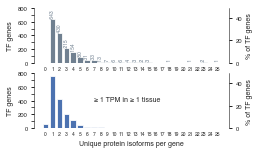

In [37]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.5, 2.2))

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs], color="slategrey")

# label n
for h, x in zip([n_iso.value_counts().to_dict().get(x, 0) for x in xs], xs):
    if h == 0:
        continue
    axs[0].text(x, h, " %s" % h, rotation=90, fontsize=fontsize-2, ha="center", va="bottom",
                color="slategrey")

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[0].set_xticks(xs)
axs[0].set_xlabel("Unique annotated protein isoforms per gene")
axs[0].tick_params(axis='x', labelsize=fontsize-2)
axs[1].set_xticks(xs)
axs[1].tick_params(axis='x', labelsize=fontsize-2)
axs[1].set_xlabel('Unique protein isoforms per gene')
#axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in ≥ 1 tissue')

def num2pct(y):
    return (y / n_iso.shape[0]) * 100

def pct2num(y):
    return (y / 100) * n_iso.shape[0]

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx.pdf',
            bbox_inches='tight')

### GTEx: downsample

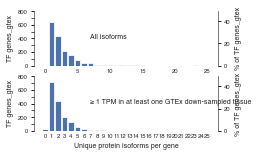

In [38]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.3, 2.2))

n_iso = (means_gtex_downsample > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_gtex_downsample > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one GTEx down-sampled tissue')

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_gtex')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes_gtex')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx_downsamp.pdf',
            bbox_inches='tight')

### Dev

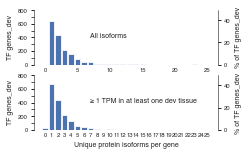

In [39]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.3, 2.2))

n_iso = (means_dev > 1).any(axis=1).groupby(genes_dev).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_dev > 1).any(axis=1).groupby(genes_dev).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one dev tissue')

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_dev')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes_dev')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx_dev.pdf',
            bbox_inches='tight')

## 6. pie charts: num isoforms in each expression bucket

### GTEx: all

1300 out of 2094 (62%) alternative isoforms ≥ 1 TPM in at least one tissue
581 out of 2094 (28%) alternative isoforms ≥ 5 TPM in at least one tissue
1004 out of 1084 (93%) MANE select isoforms ≥ 1 TPM in at least one tissue
728 out of 1084 (67%) MANE select isoforms ≥ 5 TPM in at least one tissue


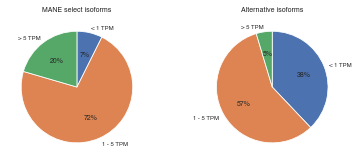

In [40]:
p = (means_gtex.loc[means_gtex.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_gtex.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/GTEx-max-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

#### GTEx all: exclude testis

1185 out of 2094 (57%) alternative isoforms ≥ 1 TPM in at least one tissue
521 out of 2094 (25%) alternative isoforms ≥ 5 TPM in at least one tissue
956 out of 1084 (88%) MANE select isoforms ≥ 1 TPM in at least one tissue
673 out of 1084 (62%) MANE select isoforms ≥ 5 TPM in at least one tissue


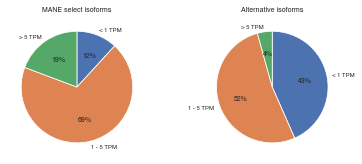

In [41]:
# Exlclude testis
cols = [c for c in means_gtex.columns if c != 'Testis']
p = (means_gtex.loc[means_gtex.index.isin(alt_isos), cols] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(alt_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), cols] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_gtex.loc[:, cols].max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/GTEx-max-expression_by-reference-vs-alternative_no-testis_pie.pdf',
            bbox_inches='tight')

### GTEx: downsample

1515 out of 2094 (72%) alternative isoforms ≥ 1 TPM in at least one tissue
795 out of 2094 (38%) alternative isoforms ≥ 5 TPM in at least one tissue
1039 out of 1084 (96%) MANE select isoforms ≥ 1 TPM in at least one tissue
809 out of 1084 (75%) MANE select isoforms ≥ 5 TPM in at least one tissue


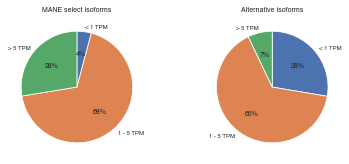

In [42]:
p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = means_gtex_downsample.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex_downsample.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = means_gtex_downsample.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex_downsample.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_gtex_downsample.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/downsampled-GTEx-control-max-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

1447 out of 2094 (69%) alternative isoforms ≥ 1 TPM in at least one tissue
724 out of 2094 (35%) alternative isoforms ≥ 5 TPM in at least one tissue
997 out of 1084 (92%) MANE select isoforms ≥ 1 TPM in at least one tissue
769 out of 1084 (71%) MANE select isoforms ≥ 5 TPM in at least one tissue


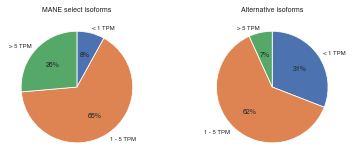

In [43]:
# Exlclude testis
cols = [c for c in means_gtex_downsample.columns if 'Testis' not in c]
p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(alt_isos), cols] >= 1).any(axis=1).sum()
n = means_gtex_downsample.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(alt_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex_downsample.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(ref_isos), cols] >= 1).any(axis=1).sum()
n = means_gtex_downsample.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(ref_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex_downsample.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_gtex_downsample.loc[:, cols].max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/downsampled-GTEx-max-expression_by-reference-vs-alternative_no-testis_pie.pdf',
            bbox_inches='tight')

### Dev

1727 out of 2094 (82%) alternative isoforms ≥ 1 TPM in at least one tissue/dev stage
1060 out of 2094 (51%) alternative isoforms ≥ 5 TPM in at least one tissue/dev stage
1044 out of 1084 (96%) MANE select isoforms ≥ 1 TPM in at least one tissue/dev stage
911 out of 1084 (84%) MANE select isoforms ≥ 5 TPM in at least one tissue/dev stage


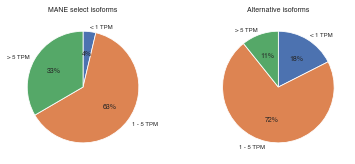

In [44]:
p = (means_dev.loc[means_dev.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = means_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = means_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue/dev stage')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_dev.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/developmental-max-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

#### Dev: no testis

1659 out of 2094 (79%) alternative isoforms ≥ 1 TPM in at least one tissue/dev stage
976 out of 2094 (47%) alternative isoforms ≥ 5 TPM in at least one tissue/dev stage
1035 out of 1084 (95%) MANE select isoforms ≥ 1 TPM in at least one tissue/dev stage
882 out of 1084 (81%) MANE select isoforms ≥ 5 TPM in at least one tissue/dev stage


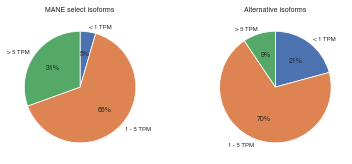

In [45]:
cols = [c for c in means_dev.columns if 'testis' not in c]
p = (means_dev.loc[means_dev.index.isin(alt_isos), cols] >= 1).any(axis=1).sum()
n = means_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(alt_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(ref_isos), cols] >= 1).any(axis=1).sum()
n = means_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(ref_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue/dev stage')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_dev.loc[:, cols].max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../../figures/developmental-max-expression_by-reference-vs-alternative_no-testis_pie.pdf',
            bbox_inches='tight')

## 7. distribution of TPMs across isoforms

### GTEx: all

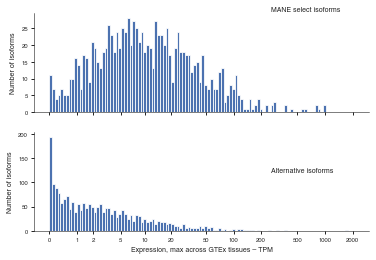

In [46]:
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[1].hist(means_gtex.max(axis=1)[means_gtex.index.isin(alt_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].hist(means_gtex.max(axis=1)[means_gtex.index.isin(ref_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=30, s='MANE select isoforms')
axs[1].text(x=8, y=120, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across GTEx tissues – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../../figures/expression_GTEX_GENCODE-isoforms_by-reference-vs-alternative.pdf',
            bbox_inches='tight')

### GTEx: downsample

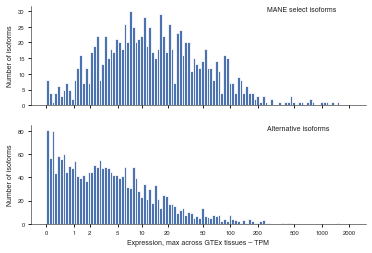

In [47]:
# plot distribution of isoforms by TPM
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[1].hist(means_gtex_downsample.max(axis=1)[means_gtex_downsample.index.isin(alt_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].hist(means_gtex_downsample.max(axis=1)[means_gtex_downsample.index.isin(ref_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=axs[0].get_ylim()[1] * 0.95, s='MANE select isoforms')
axs[1].text(x=8, y=axs[1].get_ylim()[1] * 0.95, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across GTEx tissues – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../../figures/expression_downsampled-GTEX-control_GENCODE-isoforms_by-reference-vs-alternative.pdf',
            bbox_inches='tight')

### Dev

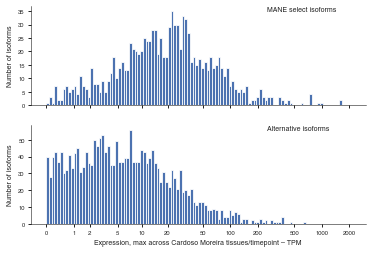

In [48]:
# plot distribution of isoforms by TPM
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[1].hist(means_dev.max(axis=1)[means_dev.index.isin(alt_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].hist(means_dev.max(axis=1)[means_dev.index.isin(ref_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=axs[0].get_ylim()[1] * 0.95, s='MANE select isoforms')
axs[1].text(x=8, y=axs[1].get_ylim()[1] * 0.95, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across Cardoso Moreira tissues/timepoint – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../../figures/expression_development_GENCODE-isoforms_by-reference-vs-alternative.pdf',
            bbox_inches='tight')

## 8. distribution of ratios across isoforms

### GTEx: all

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


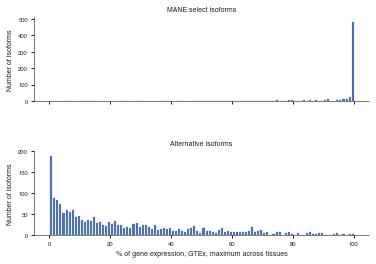

In [49]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# fraction where gene tpm > 1

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins=100
axs[0].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(ref_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(alt_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].set_xlabel('% of gene expression, GTEx, maximum across tissues')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(hspace=0.6)
fig.savefig('../../figures/expression-fraction-GTEx-max-across-tissues_ref-vs-alt_hist.pdf',
            bbox_inches='tight')


### GTEx: downsample

In [50]:
genes_gtex

UID
HES4-202      HES4
HES4-201      HES4
HES4-204      HES4
SKI-201        SKI
HES5-201      HES5
             ...  
HSFY1-202    HSFY1
HSFY1-204    HSFY1
HSFY2-202    HSFY2
HSFY2-203    HSFY2
HSFY2-201    HSFY2
Length: 4144, dtype: object

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


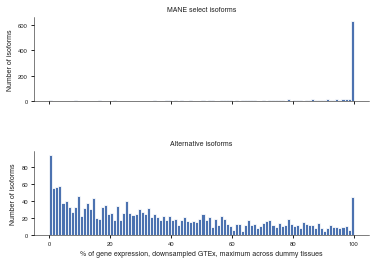

In [51]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins=100
axs[0].hist(f_gtex_downsample.max(axis=1).loc[f_gtex_downsample.index.isin(ref_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].hist(f_gtex_downsample.max(axis=1).loc[f_gtex_downsample.index.isin(alt_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].set_xlabel('% of gene expression, downsampled GTEx, maximum across dummy tissues')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(hspace=0.6)
fig.savefig('../../figures/expression-fraction-downsampled-GTEx-control-max-across-tissues_ref-vs-alt_hist.pdf',
            bbox_inches='tight')

### Dev

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


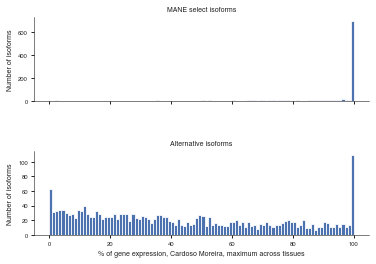

In [52]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins=100
axs[0].hist(f_dev.max(axis=1).loc[f_dev.index.isin(ref_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].hist(f_dev.max(axis=1).loc[f_dev.index.isin(alt_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].set_xlabel('% of gene expression, Cardoso Moreira, maximum across tissues')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(hspace=0.6)
fig.savefig('../../figures/expression-fraction-development-max-across-tissues_ref-vs-alt_hist.pdf',
            bbox_inches='tight')


#### aside: calculating isoforms that switch

In [53]:
TPM_THRESHOLD = 2
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= TPM_THRESHOLD)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1
f_dev = f_dev * 100

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= TPM_THRESHOLD).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1
f_gtex = f_gtex * 100

# alternative isoform > 50% in dev with corresponding ref iso > 50% in either
# plus some magnitude of change?
putative_switching_alt_isos = set(f_dev.loc[f_dev.index.isin(alt_isos) &
                                           (f_dev.max(axis=1) > 50), :].index.values)
print(len(putative_switching_alt_isos))
valid_ref_isos = (set(f_dev.loc[f_dev.index.isin(ref_isos) &
                               (f_dev.max(axis=1) > 50), :].index.values)
                        .union(
                  set(f_gtex.loc[f_gtex.index.isin(ref_isos) &
                               (f_gtex.max(axis=1) > 50), :].index.values)
                        ))
if not (genes_gtex == genes_dev).all():
        raise UserWarning()
genes = genes_gtex
genes_with_valid_ref_isos = {genes[iso] for iso in valid_ref_isos}
switching_alt_isos = {iso for iso in putative_switching_alt_isos if genes[iso] in genes_with_valid_ref_isos}
print(len(switching_alt_isos))

729
449


## 9. ref v alt 2D heatmaps: max expression

In [54]:
ref_alt_map = pd.DataFrame([ref_isos]).T
ref_alt_map.columns = ["ref"]
ref_alt_map["gene"] = ref_alt_map["ref"].str.split("|", expand=True)[0].str[:-4]

alt_isos_df = pd.DataFrame([alt_isos]).T
alt_isos_df.columns = ["alt"]
alt_isos_df["gene"] = alt_isos_df["alt"].str.split("|", expand=True)[0].str[:-4]

ref_alt_map = ref_alt_map.merge(alt_isos_df, on="gene", how="left")
print(len(ref_alt_map))
ref_alt_map_nonan = ref_alt_map[~pd.isnull(ref_alt_map["alt"])]
print(len(ref_alt_map_nonan))
ref_alt_map_nonan.head()

2910
2305


,ref,gene,alt
0,ZNF789-201,ZNF789,ZNF789-209
1,ZNF789-201,ZNF789,ZNF789-204
2,ZNF789-201,ZNF789,ZNF789-211
3,ZNF789-201,ZNF789,ZNF789-202
5,ZUP1-202,ZUP1,ZUP1-201


In [55]:
ref_alt_map_nonan[ref_alt_map_nonan["gene"] == "NKX2-5"]

,ref,gene,alt
2062,NKX2-5-201,NKX2-5,NKX2-5-202
2063,NKX2-5-201,NKX2-5,NKX2-5-204


### GTEx: all

In [56]:
means_gtex["max_gtex"] = means_gtex.max(axis=1)
means_gtex["min_gtex"] = means_gtex.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_gtex[means_gtex["max_gtex"] > 11] = 11

print(means_gtex["max_gtex"].max())
print(means_gtex["max_gtex"].min())
means_gtex_ri = means_gtex.reset_index()
means_gtex_ri["UID_rep"] = means_gtex_ri["UID"].str.replace("_", "|")

11.0
0.0


In [57]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex", "min_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex", "min_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1775
529


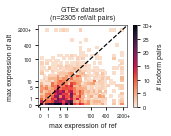

In [58]:
fig = plt.figure(figsize=(2, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_gtex_ref", y="max_gtex_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("max expression of ref")
ax.set_ylabel("max expression of alt")
ax.set_title("GTEx dataset\n(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] > ref_alt_map_nonan["max_gtex_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] < ref_alt_map_nonan["max_gtex_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/expression-scatter-ref_v_alt-gtex.pdf',
            bbox_inches='tight')

### GTEx: downsampled

In [59]:
means_gtex_downsample["max_gtex_downsample"] = means_gtex_downsample.max(axis=1)
means_gtex_downsample["min_gtex_downsample"] = means_gtex_downsample.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_gtex_downsample[means_gtex_downsample["max_gtex_downsample"] > 11] = 11

print(means_gtex_downsample["max_gtex_downsample"].max())
print(means_gtex_downsample["max_gtex_downsample"].min())
means_gtex_downsample_ri = means_gtex_downsample.reset_index()
means_gtex_downsample_ri["UID_rep"] = means_gtex_downsample_ri["UID"].str.replace("_", "|")

11.0
0.0


In [60]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_downsample_ri[["UID_rep", "max_gtex_downsample",
                                                                      "min_gtex_downsample"]], 
                                            left_on="ref", right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_downsample_ri[["UID_rep", "max_gtex_downsample",
                                                                      "min_gtex_downsample"]], 
                                            left_on="alt", right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1777
527


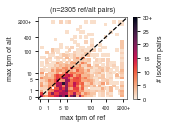

In [61]:
fig = plt.figure(figsize=(2, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_gtex_downsample_ref", y="max_gtex_downsample_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("max tpm of ref")
ax.set_ylabel("max tpm of alt")
ax.set_title("(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_downsample_ref"] > ref_alt_map_nonan["max_gtex_downsample_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_downsample_ref"] < ref_alt_map_nonan["max_gtex_downsample_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/expression-scatter-ref_v_alt-gtex-downsample.pdf',
            bbox_inches='tight')

### Dev

In [62]:
means_dev["max_dev"] = means_dev.max(axis=1)
means_dev["min_dev"] = means_dev.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_dev[means_dev["max_dev"] > 11] = 11

print(means_dev["max_dev"].max())
print(means_dev["max_dev"].min())
means_dev_ri = means_dev.reset_index()
means_dev_ri["UID_rep"] = means_dev_ri["UID"].str.replace("_", "|")

11.0
0.0


In [63]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev", "min_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev", "min_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1752
551


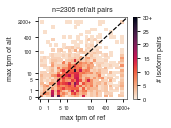

In [64]:
fig = plt.figure(figsize=(2, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_dev_ref", y="max_dev_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("max tpm of ref")
ax.set_ylabel("max tpm of alt")
ax.set_title("n=%s ref/alt pairs" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] > ref_alt_map_nonan["max_dev_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] < ref_alt_map_nonan["max_dev_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/expression-scatter-ref_v_alt-dev.pdf',
            bbox_inches='tight')

## 10. per isoform: max v min ratio

removing NaNs - not counting anything where *gene* expression < 1

### GTEx: all

In [65]:
print(len(f_gtex))
f_gtex["max_ratio_gtex"] = f_gtex.max(axis=1)
f_gtex["min_ratio_gtex"] = f_gtex.min(axis=1)
f_gtex_nonan = f_gtex[(~pd.isnull(f_gtex["max_ratio_gtex"])) & (~pd.isnull(f_gtex["min_ratio_gtex"]))]
print(len(f_gtex_nonan))

f_gtex_ri = f_gtex_nonan.reset_index()
f_gtex_ri["UID_rep"] = f_gtex_ri["UID"].str.replace("_", "|")

4144
4013


In [66]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

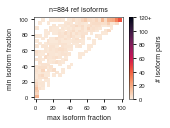

In [67]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["ref", "min_ratio_gtex_ref", "max_ratio_gtex_ref"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_gtex_ref"])) & (~pd.isnull(df["max_ratio_gtex_ref"]))]

ax = sns.histplot(data=df, x="min_ratio_gtex_ref", y="max_ratio_gtex_ref",
                  bins=30, cbar=True, cmap="rocket_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("max isoform fraction")
ax.set_ylabel("min isoform fraction")
ax.set_title("n=%s ref isoforms" % len(df))

fig.savefig('../../figures/expression-ratio-scatter-ref-gtex.pdf',
            bbox_inches='tight')

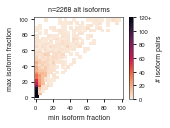

In [68]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["alt", "min_ratio_gtex_alt", "max_ratio_gtex_alt"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_gtex_alt"])) & (~pd.isnull(df["max_ratio_gtex_alt"]))]

ax = sns.histplot(data=ref_alt_map_nonan, x="min_ratio_gtex_alt", y="max_ratio_gtex_alt",
                  bins=30, cbar=True, cmap="rocket_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))
fig.savefig('../../figures/expression-ratio-scatter-alt-gtex.pdf',
            bbox_inches='tight')

### GTEx: downsample

In [69]:
print(len(f_gtex_downsample))
f_gtex_downsample["max_ratio_gtex_downsample"] = f_gtex_downsample.max(axis=1)
f_gtex_downsample["min_ratio_gtex_downsample"] = f_gtex_downsample.min(axis=1)
f_gtex_downsample_nonan = f_gtex_downsample[(~pd.isnull(f_gtex_downsample["max_ratio_gtex_downsample"])) & 
                                            (~pd.isnull(f_gtex_downsample["min_ratio_gtex_downsample"]))]
print(len(f_gtex_downsample_nonan))

f_gtex_downsample_ri = f_gtex_downsample_nonan.reset_index()
f_gtex_downsample_ri["UID_rep"] = f_gtex_downsample_ri["UID"].str.replace("_", "|")

4144
4101


In [70]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_downsample_ri[["UID_rep", "max_ratio_gtex_downsample", 
                                                       "min_ratio_gtex_downsample"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_downsample_ri[["UID_rep", "max_ratio_gtex_downsample", 
                                                                  "min_ratio_gtex_downsample"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

69


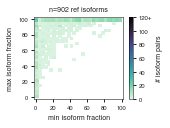

In [71]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["ref", "min_ratio_gtex_downsample_ref", "max_ratio_gtex_downsample_ref"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_gtex_downsample_ref"])) & (~pd.isnull(df["max_ratio_gtex_downsample_ref"]))]

n_switches = df[(df["min_ratio_gtex_downsample_ref"] < 10) & (df["max_ratio_gtex_downsample_ref"] > 90)]
n_off = df[(df["min_ratio_gtex_downsample_ref"] < 10) & (df["max_ratio_gtex_downsample_ref"] < 10)]
print(len(n_switches))
p_switches_ref_gtex_ds = len(n_switches)/len(df)
p_off_ref_gtex_ds = len(n_off)/len(df)

ax = sns.histplot(data=df, x="min_ratio_gtex_downsample_ref", y="max_ratio_gtex_downsample_ref",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s ref isoforms" % len(df))
fig.savefig('../../figures/expression-ratio-scatter-ref-gtex-downsample.pdf',
            bbox_inches='tight')

68


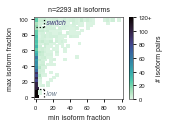

In [72]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["alt", "min_ratio_gtex_downsample_alt", "max_ratio_gtex_downsample_alt"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_gtex_downsample_alt"])) & (~pd.isnull(df["max_ratio_gtex_downsample_alt"]))]

n_switches = df[(df["min_ratio_gtex_downsample_alt"] < 10) & (df["max_ratio_gtex_downsample_alt"] > 90)]
n_off = df[(df["min_ratio_gtex_downsample_alt"] < 10) & (df["max_ratio_gtex_downsample_alt"] < 10)]
print(len(n_switches))
p_switches_alt_gtex_ds = len(n_switches)/len(df)
p_off_alt_gtex_ds = len(n_off)/len(df)

ax = sns.histplot(data=ref_alt_map_nonan, x="min_ratio_gtex_downsample_alt", y="max_ratio_gtex_downsample_alt",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))

# add lines to distinguish events
ax.plot([10, 0], [10, 10], linestyle="dotted", color="black")
ax.plot([10, 10], [0, 10], linestyle="dotted", color="black")
ax.plot([0, 10], [90, 90], linestyle="dotted", color="black")
ax.plot([10, 10], [90, 100], linestyle="dotted", color="black")
ax.text(10, 5, " low", ha="left", va="center", fontstyle="italic", color="slategrey")
ax.text(10, 95, " switch", ha="left", va="center", fontstyle="italic", color=sns.color_palette("mako")[1])

fig.savefig('../../figures/expression-ratio-scatter-alt-gtex-downsample.pdf',
            bbox_inches='tight')

### Dev

In [73]:
print(len(f_dev))
f_dev["max_ratio_dev"] = f_dev.max(axis=1)
f_dev["min_ratio_dev"] = f_dev.min(axis=1)
f_dev_nonan = f_dev[(~pd.isnull(f_dev["max_ratio_dev"])) & (~pd.isnull(f_dev["min_ratio_dev"]))]
print(len(f_dev_nonan))

f_dev_ri = f_dev_nonan.reset_index()
f_dev_ri["UID_rep"] = f_dev_ri["UID"].str.replace("_", "|")

4144
4078


In [74]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

113


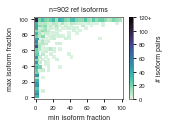

In [75]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["ref", "min_ratio_dev_ref", "max_ratio_dev_ref"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_dev_ref"])) & (~pd.isnull(df["max_ratio_dev_ref"]))]

n_switches = df[(df["min_ratio_dev_ref"] < 10) & (df["max_ratio_dev_ref"] > 90)]
n_off = df[(df["min_ratio_dev_ref"] < 10) & (df["max_ratio_dev_ref"] < 10)]
print(len(n_switches))
p_switches_ref_dev = len(n_switches)/len(df)
p_off_ref_dev = len(n_off)/len(df)

ax = sns.histplot(data=ref_alt_map_nonan, x="min_ratio_dev_ref", y="max_ratio_dev_ref",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s ref isoforms" % len(df))

# # add lines to distinguish events
# ax.plot([20, 0], [20, 20], linestyle="dotted", color="black")
# ax.plot([20, 20], [0, 20], linestyle="dotted", color="black")
# ax.plot([0, 20], [70, 70], linestyle="dotted", color="black")
# ax.plot([20, 20], [70, 100], linestyle="dotted", color="black")
# ax.text(20, 10, " low", ha="left", va="center", fontstyle="italic", color="slategrey")
# ax.text(20, 85, " switch", ha="left", va="center", fontstyle="italic", color=sns.color_palette("mako")[0])

fig.savefig('../../figures/expression-ratio-scatter-ref-dev.pdf',
            bbox_inches='tight')

117


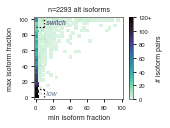

In [76]:
fig = plt.figure(figsize=(2, 1.5))

df = ref_alt_map_nonan[["alt", "min_ratio_dev_alt", "max_ratio_dev_alt"]].drop_duplicates()
df = df[(~pd.isnull(df["min_ratio_dev_alt"])) & (~pd.isnull(df["max_ratio_dev_alt"]))]

n_switches = df[(df["min_ratio_dev_alt"] < 10) & (df["max_ratio_dev_alt"] > 90)]
n_off = df[(df["min_ratio_dev_alt"] < 10) & (df["max_ratio_dev_alt"] < 10)]
print(len(n_switches))
p_switches_alt_dev = len(n_switches)/len(df)
p_off_alt_dev = len(n_off)/len(df)

ax = sns.histplot(data=ref_alt_map_nonan, x="min_ratio_dev_alt", y="max_ratio_dev_alt",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "# isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xlabel("min isoform fraction")
ax.set_ylabel("max isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))

# add lines to distinguish events
ax.plot([10, 0], [10, 10], linestyle="dotted", color="black")
ax.plot([10, 10], [0, 10], linestyle="dotted", color="black")
ax.plot([0, 10], [90, 90], linestyle="dotted", color="black")
ax.plot([10, 10], [90, 100], linestyle="dotted", color="black")
ax.text(10, 5, " low", ha="left", va="center", fontstyle="italic", color="slategrey")
ax.text(10, 95, " switch", ha="left", va="center", fontstyle="italic", color=sns.color_palette("mako")[1])

fig.savefig('../../figures/expression-ratio-scatter-alt-dev.pdf',
            bbox_inches='tight')

In [77]:
bar = pd.DataFrame.from_dict({"gtex_ds_ref": {"switch": p_switches_ref_gtex_ds*100, "low": p_off_ref_gtex_ds*100},
                              "gtex_ds_alt": {"switch": p_switches_alt_gtex_ds*100, "low": p_off_alt_gtex_ds*100},
                              "dev_ref": {"switch": p_switches_ref_dev*100, "low": p_off_ref_dev*100},
                              "dev_alt": {"switch": p_switches_alt_dev*100, "low": p_off_alt_dev*100}}, 
                             orient="index").reset_index()
bar["shift"] = 100-(bar["switch"]+bar["low"])
bar = bar[["index", "low", "switch", "shift"]]
bar

,index,low,switch,shift
0,gtex_ds_ref,2.660754,7.649667,89.689579
1,gtex_ds_alt,21.849106,2.965547,75.185347
2,dev_ref,3.104213,12.527716,84.368071
3,dev_alt,17.924117,5.102486,76.973397


In [78]:
palette = {"low": "lightgrey",
           "switch": sns.color_palette("mako")[1],
           "shift": sns.color_palette("mako")[5]}
palette

{'low': 'lightgrey',
 'switch': (0.25307401, 0.23772973, 0.48316271),
 'shift': (0.54578602, 0.8544913, 0.69848331)}

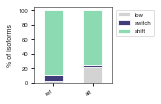

In [79]:
gtex_bar = bar[bar["index"].str.contains("gtex")]
ax = gtex_bar.plot.bar(x="index", stacked=True, color=palette.values(), figsize=(1.4, 1.4))
ax.set_ylabel("% of isoforms")
ax.set_xlabel("")
#ax.set_title("GTEx")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))
ax.set_xticklabels(["ref", "alt"], ha="right", va="top", rotation=30)

plt.savefig('../../figures/expression-switch-bar-gtex.pdf',
            bbox_inches='tight')

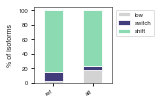

In [80]:
dev_bar = bar[bar["index"].str.contains("dev")]
ax = dev_bar.plot.bar(x="index", stacked=True, color=palette.values(), figsize=(1.4, 1.4))
ax.set_ylabel("% of isoforms")
ax.set_xlabel("")
#ax.set_title("dev")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))
ax.set_xticklabels(["ref", "alt"], ha="right", va="top", rotation=30)

plt.savefig('../../figures/expression-switch-bar-dev.pdf',
            bbox_inches='tight')

### example plot: TF gene whose isoform ratios change across tissues

In [81]:
tmp = ref_alt_map_nonan
tmp["mm_gtex_ds_ref"] = tmp["max_ratio_gtex_downsample_ref"]-tmp["min_ratio_gtex_downsample_ref"]
tmp["mm_gtex_ds_alt"] = tmp["max_ratio_gtex_downsample_alt"]-tmp["min_ratio_gtex_downsample_alt"]
tmp["mm_dev_ref"] = tmp["max_ratio_dev_ref"]-tmp["min_ratio_dev_ref"]
tmp["mm_dev_alt"] = tmp["max_ratio_dev_alt"]-tmp["min_ratio_dev_alt"]
tmp["dg_ref"] = tmp["mm_dev_ref"]-tmp["mm_gtex_ds_ref"]
tmp["dg_alt"] = tmp["mm_dev_alt"]-tmp["mm_gtex_ds_alt"]
#tmp.sort_values(by="dg_alt", ascending=False).head(30)

In [82]:
def developmental_tissue_expression_plot(gene_name, palette_name, figsize, ylim, means, cols, fig_suffix):
    n_isos = len(means.loc[genes == gene_name])
    palette = sns.color_palette(palette_name, as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[genes == gene_name, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(tpm + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

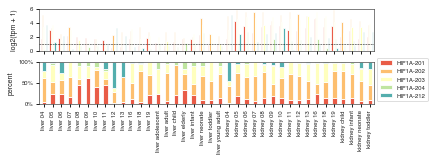

In [83]:
liver_cols = [x for x in means_dev.columns if "liver" in x]
kidney_cols = [x for x in means_dev.columns if "kidney" in x]
developmental_tissue_expression_plot("HIF1A", "Spectral", (6, 1.75), (0, 6), means_dev, liver_cols + kidney_cols, 
                                     "means_dev_liver_kidney")

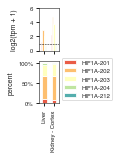

In [84]:
liver_cols = [x for x in means_gtex.columns if "Liver" in x]
kidney_cols = [x for x in means_gtex.columns if "Kidney" in x]
developmental_tissue_expression_plot("HIF1A", "Spectral", (0.35, 1.75), (0, 6), means_gtex, liver_cols + kidney_cols, 
                                     "means_gtex_liver_kidney")

In [85]:
tmp_nn = tmp[(~pd.isnull(tmp["min_ratio_dev_alt"])) & (~pd.isnull(tmp["max_ratio_dev_alt"]))]
tmp_srt = tmp_nn[(tmp_nn["max_ratio_dev_alt"] > 90) & (tmp_nn["min_ratio_dev_alt"] < 10)]
tmp_srt[["gene", "ref", "alt", "max_ratio_dev_alt", 
         "min_ratio_dev_alt", "max_dev_alt", "min_dev_alt"]].sort_values(by="max_ratio_dev_alt", ascending=False).head(20)

,gene,ref,alt,max_ratio_dev_alt,min_ratio_dev_alt,max_dev_alt,min_dev_alt
579,ZNF385A,ZNF385A-203|ZNF385A-205|ZNF385A-212,ZNF385A-201,100.0,0.000000,4.175525,0.000000
1480,MGA,MGA-201|MGA-211,MGA-202|MGA-207,100.0,5.676099,4.763720,0.412521
365,ZNF488,ZNF488-201,ZNF488-202,100.0,0.000001,3.631446,0.000000
993,ZBTB18,ZBTB18-201,ZBTB18-202,100.0,0.583387,8.586258,0.248745
1612,NFKB1,NFKB1-201|NFKB1-213,NFKB1-202|NFKB1-205,100.0,0.000065,4.678362,0.000000
686,HES6,HES6-201,HES6-202,100.0,0.000000,5.770591,0.000000
517,ZNF317,ZNF317-201,ZNF317-202,100.0,0.000000,2.952675,0.000000
283,DPF3,DPF3-210,DPF3-203,100.0,9.198564,4.621072,0.081506
1284,RELB,RELB-201|RELB-207,RELB-202,100.0,0.000000,2.000797,0.000000
1748,ZNF341,ZNF341-202,ZNF341-201,100.0,0.000000,1.966947,0.000000


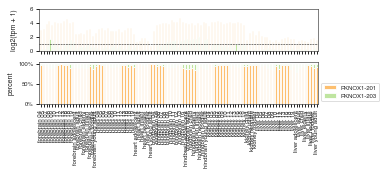

In [86]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "_dev" not in x]
notestis_cols = [x for x in notestis_cols if "ovary" not in x]
developmental_tissue_expression_plot("PKNOX1", "Spectral", (5, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis")

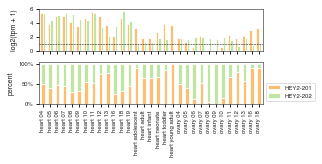

In [87]:
heart_cols = [x for x in means_dev.columns if "heart" in x]
ovary_cols = [x for x in means_dev.columns if "ovary" in x]
developmental_tissue_expression_plot("HEY2", "Spectral", (4, 1.75), (0, 6), means_dev, heart_cols + ovary_cols, 
                                     "means_dev_heart_ovary")

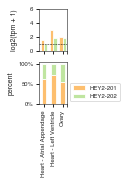

In [88]:
heart_cols = [x for x in means_gtex.columns if "Heart" in x]
ovary_cols = [x for x in means_gtex.columns if "Ovary" in x]
developmental_tissue_expression_plot("HEY2", "Spectral", (0.5, 1.75), (0, 6), means_gtex, heart_cols + ovary_cols, 
                                     "means_gtex_heart_ovary")

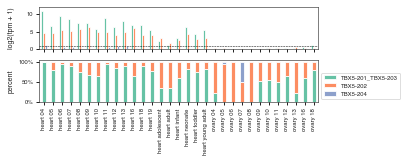

In [89]:
heart_cols = [x for x in means_dev.columns if "heart" in x]
ovary_cols = [x for x in means_dev.columns if "ovary" in x]
developmental_tissue_expression_plot("TBX5", "Set2", (5, 1.75), (0, 12), means_dev, heart_cols + ovary_cols, 
                                     "means_dev_heart_ovary")

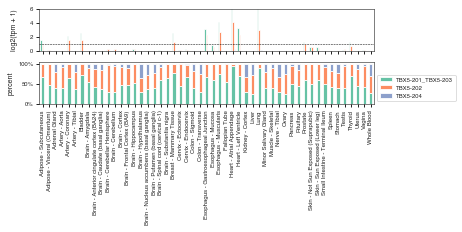

In [90]:
gtex_cols = [x for x in means_gtex.columns if "_gtex" not in x]
developmental_tissue_expression_plot("TBX5", "Set2", (6, 1.75), (0, 6), means_gtex, gtex_cols, 
                                     "means_gtex")

In [91]:
ss_alt = len(ref_alt_map_nonan[(ref_alt_map_nonan["max_ratio_gtex_downsample_alt"] >= 10)].gene.unique())
ss_alt

850

In [92]:
ss_alt = len(ref_alt_map_nonan[(ref_alt_map_nonan["max_ratio_dev_alt"] >= 10)].gene.unique())
ss_alt

864

In [93]:
len(ref_alt_map_nonan.gene.unique())

909

In [94]:
864/909

0.9504950495049505

## 11. plot number of transcripts over time from Gencode

In [95]:
genc = pd.read_table("../../data/external/gencode_history.txt")
genc.head()

,release,freeze_date,n_genes,n_pc_genes,n_tx,n_pc_tx,n_full-length_pc_tx
0,43,2022_08,62703,19393,252913,89411,64004
1,42,2022_04,62696,19379,252416,89305,63972
2,41,2022_01,61852,19370,251236,88780,63370
3,40,2021_08,61544,19988,246624,87814,62232
4,39,2021_05,61533,19982,244939,87151,61516


In [96]:
genc_melt = pd.melt(genc, id_vars=["release", "freeze_date"])
genc_melt.head()

,release,freeze_date,variable,value
0,43,2022_08,n_genes,62703
1,42,2022_04,n_genes,62696
2,41,2022_01,n_genes,61852
3,40,2021_08,n_genes,61544
4,39,2021_05,n_genes,61533


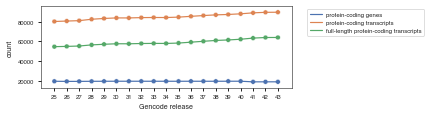

In [97]:
fig = plt.figure(figsize=(4.5, 1.5))

ax = sns.lineplot(data=genc_melt[~genc_melt["variable"].isin(["n_tx", "n_genes"])], 
                  x="release", y="value", hue="variable")
sns.scatterplot(data=genc_melt[~genc_melt["variable"].isin(["n_tx", "n_genes"])], 
                  x="release", y="value", hue="variable", ax=ax)

_ = ax.set_xticks(list(genc_melt["release"].unique()))

ax.set_xlabel("Gencode release")
ax.set_ylabel("count")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1), labels=["protein-coding genes", 
                                                    "protein-coding transcripts", 
                                                    "full-length protein-coding transcripts"])

fig.savefig("../../figures/Gencode_over_time.pdf", bbox_inches="tight", dpi="figure")

### # make domain figure - move this into domain notebook at some point

In [98]:
# loop through ref/alt pairs above and calculate total num AAs inserted/deleted/frameshifted
tot_ins = []
tot_perc_ins = []
tot_dd = []
tot_perc_dd = []
tot_f = []
tot_perc_f = []

tot_ins_dom = []
tot_perc_ins_dom = []
tot_dd_dom = []
tot_perc_dd_dom = []
tot_f_dom = []
tot_perc_f_dom = []

tot_ins_eff = []
tot_perc_ins_eff = []
tot_dd_eff = []
tot_perc_dd_eff = []
tot_f_eff = []
tot_perc_f_eff = []

for i, row in ref_alt_map_nonan.iterrows():
    ref = row.ref.split("|")[0]
    alt = row.alt.split("|")[0]
    gene = ref[:-4]
    
    # manual fixes
    if gene == "AC092072.1":
        gene = "ZNF223"
    if gene == "AC008554.1":
        gene = "ZNF737"
    if gene == "AC073611.1":
        gene = "SP7"
    if gene == "AC118549.1":
        gene = "ZZZ3"
    if gene == "ZUP1":
        gene = "ZUFSP"
    if gene == "AC139768.1":
        gene = "POU6F1"
    if gene == "PHF19":
        gene = "PHF19 "
    #print("gene: %s | ref: %s | alt: %s" % (gene, ref, alt))
    
    pp_str = tfs[gene].pairwise_changes_relative_to_reference(ref, alt)
    aa_ftr = tfs[gene].aa_feature_disruption(ref)
    if len(aa_ftr) == 0:
        ins_dom = 0
        perc_ins_dom = 0
        dd_dom = 0
        perc_dd_dom = 0
        f_dom = 0
        perc_f_dom = 0
        
        ins_eff = 0
        perc_ins_eff = 0
        dd_eff = 0
        perc_dd_eff = 0
        f_eff = 0
        perc_f_eff = 0
    else:
        aa_ftr_alt = aa_ftr[aa_ftr["alt_iso"] == alt]
        
        # separate pfam and effector domains
        pfam = aa_ftr_alt[aa_ftr_alt["category"] == "Pfam_domain"]
        eff = aa_ftr_alt[aa_ftr_alt["category"] == "effector_domain"]
        
        if len(pfam) > 0:
            pfam_grp = pfam.groupby("alt_iso")[["deletion", "insertion", "frameshift"]].agg("sum").reset_index()
        
            ins_dom = pfam_grp.insertion.iloc[0]
            perc_ins_dom = ins_dom/len(pp_str)*100
            dd_dom = pfam_grp.deletion.iloc[0]
            perc_dd_dom = dd_dom/len(pp_str)*100
            f_dom = pfam_grp.frameshift.iloc[0]
            perc_f_dom = f_dom/len(pp_str)*100
        else:
            ins_dom = 0
            perc_ins_dom = 0
            dd_dom = 0
            perc_dd_dom = 0
            f_dom = 0
            perc_f_dom = 0
            
        if len(eff) > 0:
            eff_grp = eff.groupby("alt_iso")[["deletion", "insertion", "frameshift"]].agg("sum").reset_index()
        
            ins_eff = eff_grp.insertion.iloc[0]
            perc_ins_eff = ins_eff/len(pp_str)*100
            dd_eff = eff_grp.deletion.iloc[0]
            perc_dd_eff = dd_eff/len(pp_str)*100
            f_eff = eff_grp.frameshift.iloc[0]
            perc_f_eff = f_eff/len(pp_str)*100
        else:
            ins_eff = 0
            perc_ins_eff = 0
            dd_eff = 0
            perc_dd_eff = 0
            f_eff = 0
            perc_f_eff = 0
        
        
    
    
    ins = pp_str.count("I")
    perc_ins = ins/len(pp_str)*100
    dd = pp_str.count("D")
    perc_dd = dd/len(pp_str)*100
    f = pp_str.count("F")
    f += pp_str.count("f")
    perc_f = f/len(pp_str)*100
    
    tot_ins.append(ins)
    tot_perc_ins.append(perc_ins)
    tot_dd.append(dd)
    tot_perc_dd.append(perc_dd)
    tot_f.append(f)
    tot_perc_f.append(perc_f)
    
    tot_ins_dom.append(ins_dom)
    tot_perc_ins_dom.append(perc_ins_dom)
    tot_dd_dom.append(dd_dom)
    tot_perc_dd_dom.append(perc_dd_dom)
    tot_f_dom.append(f_dom)
    tot_perc_f_dom.append(perc_f_dom)
    
    tot_ins_eff.append(ins_eff)
    tot_perc_ins_eff.append(perc_ins_eff)
    tot_dd_eff.append(dd_eff)
    tot_perc_dd_eff.append(perc_dd_eff)
    tot_f_eff.append(f_eff)
    tot_perc_f_eff.append(perc_f_eff)

ref_alt_map_nonan["n_ins"] = tot_ins
ref_alt_map_nonan["perc_ins"] = tot_perc_ins
ref_alt_map_nonan["n_dd"] = tot_dd
ref_alt_map_nonan["perc_dd"] = tot_perc_dd
ref_alt_map_nonan["n_f"] = tot_f
ref_alt_map_nonan["perc_f"] = tot_perc_f

ref_alt_map_nonan["n_ins_dom"] = tot_ins_dom
ref_alt_map_nonan["perc_ins_dom"] = tot_perc_ins_dom
ref_alt_map_nonan["n_dd_dom"] = tot_dd_dom
ref_alt_map_nonan["perc_dd_dom"] = tot_perc_dd_dom
ref_alt_map_nonan["n_f_dom"] = tot_f_dom
ref_alt_map_nonan["perc_f_dom"] = tot_perc_f_dom

ref_alt_map_nonan["n_ins_eff"] = tot_ins_eff
ref_alt_map_nonan["perc_ins_eff"] = tot_perc_ins_eff
ref_alt_map_nonan["n_dd_eff"] = tot_dd_eff
ref_alt_map_nonan["perc_dd_eff"] = tot_perc_dd_eff
ref_alt_map_nonan["n_f_eff"] = tot_f_eff
ref_alt_map_nonan["perc_f_eff"] = tot_perc_f_eff

ref_alt_map_nonan.sample(5)

,ref,gene,alt,UID_rep_ref,max_gtex_ref,min_gtex_ref,UID_rep_alt,max_gtex_alt,min_gtex_alt,UID_rep_ref,...,n_dd_dom,perc_dd_dom,n_f_dom,perc_f_dom,n_ins_eff,perc_ins_eff,n_dd_eff,perc_dd_eff,n_f_eff,perc_f_eff
1560,SP3-201,SP3,SP3-203,SP3-201,2.039102,0.588168,SP3-203,3.040314,0.436485,SP3-201,...,0,0.000000,0,0.0,0,0.0,68,8.706786,0,0.000000
309,LCOR-205,LCOR,LCOR-209,LCOR-205,1.501464,0.434278,LCOR-209,0.020158,0.000000,LCOR-205,...,468,25.269978,0,0.0,0,0.0,0,0.000000,0,0.000000
1372,ZNF763-202,ZNF763,ZNF763-201,ZNF763-202,0.567514,0.014028,ZNF763-201,2.662571,0.441363,ZNF763-202,...,0,0.000000,0,0.0,0,0.0,0,0.000000,0,0.000000
880,TCF4-201|TCF4-267,TCF4,TCF4-280|TCF4-290,TCF4-201|TCF4-267,0.065924,0.000000,TCF4-280|TCF4-290,1.005603,0.001885,TCF4-201|TCF4-267,...,0,0.000000,0,0.0,0,0.0,100,14.903130,0,0.000000
1623,PAX6-202|PAX6-207|PAX6-209|PAX6-231|PAX6-243|P...,PAX6,PAX6-236,PAX6-202|PAX6-207|PAX6-209|PAX6-231|PAX6-243|P...,11.000000,11.000000,PAX6-236,1.472808,0.000000,PAX6-202|PAX6-207|PAX6-209|PAX6-231|PAX6-243|P...,...,139,25.836431,0,0.0,0,0.0,50,9.293680,28,5.204461


In [99]:
def mimic_r_boxplot(ax):
    for i, patch in enumerate(ax.artists):
        r, g, b, a = patch.get_facecolor()
        col = (r, g, b, 1)
        patch.set_facecolor((r, g, b, .5))
        patch.set_edgecolor((r, g, b, 1))

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        line_order = ["lower", "upper", "whisker_1", "whisker_2", "med", "fliers"]
        for j in range(i*6,i*6+6):
            elem = line_order[j%6]
            line = ax.lines[j]
            if "whisker" in elem:
                line.set_visible(False)
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
            if "fliers" in elem:
                line.set_alpha(0.5)

In [100]:
def comp_cat(row):
    if "dom" in row.variable:
        return "pfam"
    elif "eff" in row.variable:
        return "effector"
    else:
        return "total"

In [101]:
to_plot = pd.melt(ref_alt_map_nonan, id_vars=["ref", "gene", "alt"], value_vars=["n_ins", "perc_ins",
                                                                                 "n_dd", "perc_dd",
                                                                                 "n_f", "perc_f",
                                                                                 "n_ins_dom", "perc_ins_dom",
                                                                                 "n_dd_dom", "perc_dd_dom",
                                                                                 "n_f_dom", "perc_f_dom",
                                                                                 "n_ins_eff", "perc_ins_eff",
                                                                                 "n_dd_eff", "perc_dd_eff",
                                                                                 "n_f_eff", "perc_f_eff"])
to_plot["n_or_perc"] = to_plot["variable"].str.split("_", expand=True)[0]
to_plot["type"] = to_plot["variable"].str.split("_", expand=True)[1]
to_plot["dom_cat"] = to_plot.apply(comp_cat, axis=1)
to_plot.sample(5)

,ref,gene,alt,variable,value,n_or_perc,type,dom_cat
8687,ZNF19-201|ZNF19-205,ZNF19,ZNF19-208,perc_dd,9.170306,perc,dd,total
707,ZNF773-201,ZNF773,ZNF773-202,n_ins,15.000000,n,ins,total
35533,DACH2-201,DACH2,DACH2-202,perc_dd_eff,0.000000,perc,dd,effector
12968,IKZF3-203,IKZF3,IKZF3-210,perc_f,0.000000,perc,f,total
5605,SOX15-201|SOX15-202,SOX15,SOX15-203,n_dd,55.000000,n,dd,total


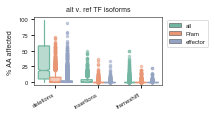

In [102]:
fig = plt.figure(figsize=(2.3, 1.25))
ax = sns.boxplot(data=to_plot[to_plot["n_or_perc"] == "perc"], 
                 x="type", y="value", hue="dom_cat", order=["dd", "ins", "f"],
                 palette=sns.color_palette("Set2"), fliersize=5, notch=True,
                 flierprops={"marker": "."})
mimic_r_boxplot(ax)


ax.set_xlabel("")
ax.set_xticklabels(["deletions", "insertions", "frameshift"], rotation=30, ha="right", va="top")
ax.set_ylabel("% AA affected")
ax.set_title("alt v. ref TF isoforms")
handles, labels = ax.get_legend_handles_labels()
labels = ["all", "Pfam", "effector"]
ax.legend(handles, labels, loc=2, bbox_to_anchor=(1.01, 1))
fig.savefig('../../figures/domain-overall-boxplot.pdf',
            bbox_inches='tight')

In [103]:
to_plot[to_plot["n_or_perc"] == "perc"].groupby(["type", "dom_cat"]).agg("median")

value
type dom_cat            
dd   effector   0.000000
     pfam       0.000000
     total     18.681319
f    effector   0.000000
     pfam       0.000000
     total      0.000000
ins  effector   0.000000
     pfam       0.000000
     total      0.503356

In [104]:
len(ref_alt_map_nonan[ref_alt_map_nonan["perc_f_dom"] > 0])

146

In [105]:
len(ref_alt_map_nonan[ref_alt_map_nonan["perc_ins"] >= 10])

195

In [106]:
len(ref_alt_map_nonan[ref_alt_map_nonan["perc_f"] >= 10])

68

In [107]:
len(ref_alt_map_nonan)

2305

In [108]:
214/2305

0.0928416485900217

In [109]:
len(ref_alt_map_nonan[(ref_alt_map_nonan["perc_dd_eff"] > 0) |
                      (ref_alt_map_nonan["perc_ins_eff"] > 0) |
                      (ref_alt_map_nonan["perc_f_eff"] > 0)])

684

In [110]:
684/2305

0.2967462039045553